<a href="https://colab.research.google.com/github/abhijeetanand9875/CodeClause/blob/main/CodeClauseInternship_Web_Traffic_Times_Series_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv('webtraffic.csv')

In [ ]:
df.head()

,Hour Index,Sessions
0,0,1418159421
1,1,1113769116
2,2,919158921
3,3,822352824
4,4,735526737


In [ ]:
df.shape

(4896, 2)

Data Exploration for Web Traffic Forecasting

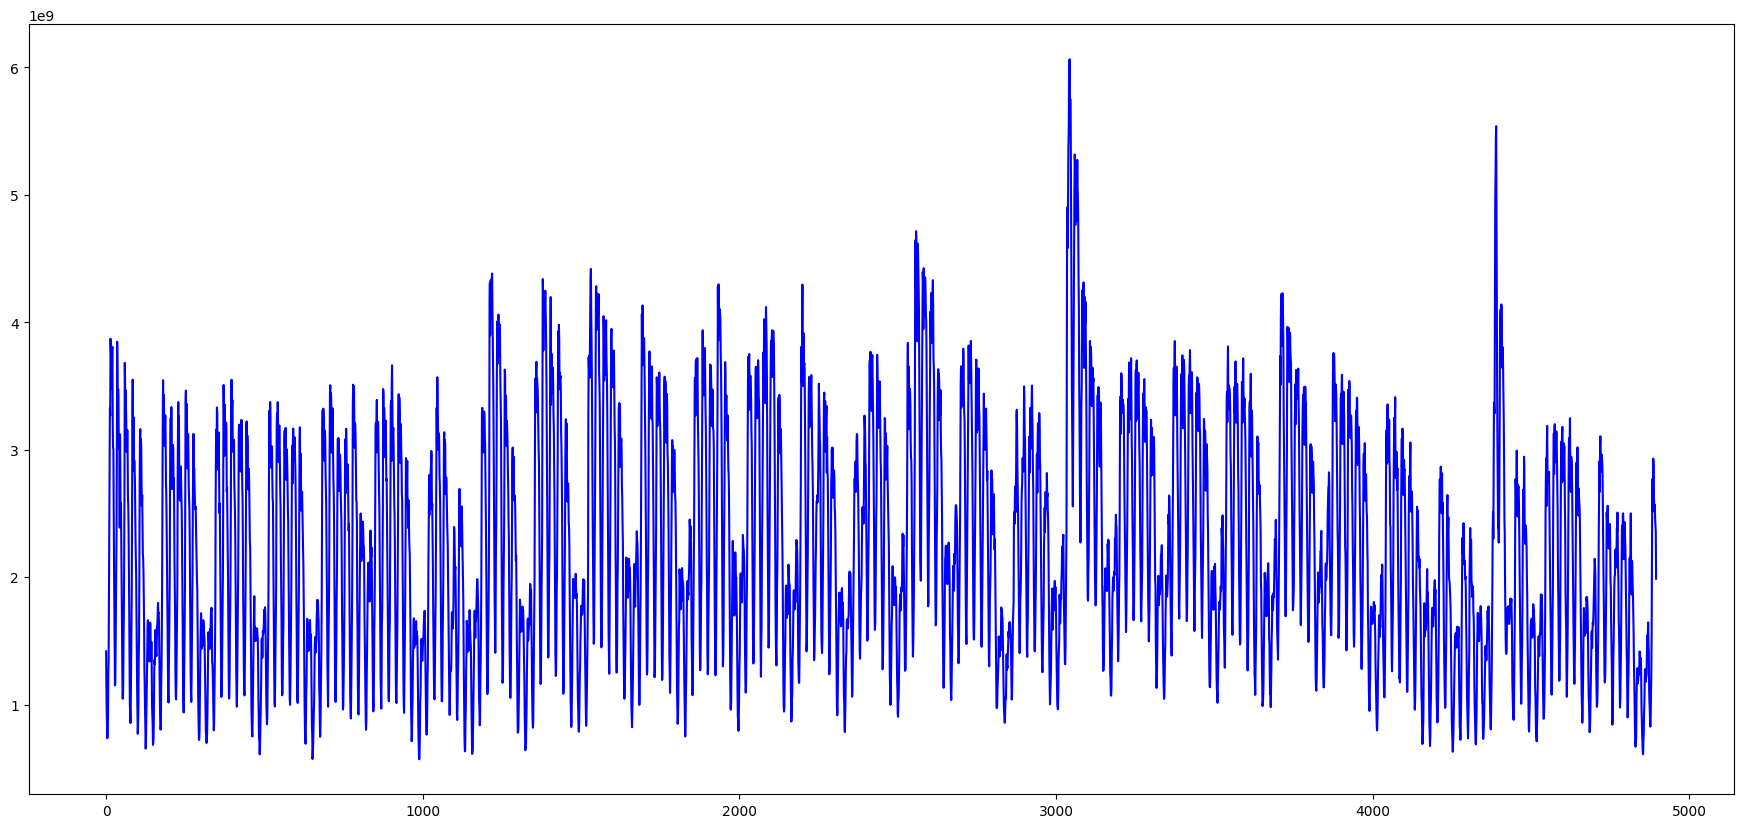

In [ ]:
import matplotlib.pyplot as plt
sessions = df['Sessions'].values
ar = np.arange(len(sessions))
plt.figure(figsize=(22,10))
plt.plot(ar, sessions,'b')
plt.show()

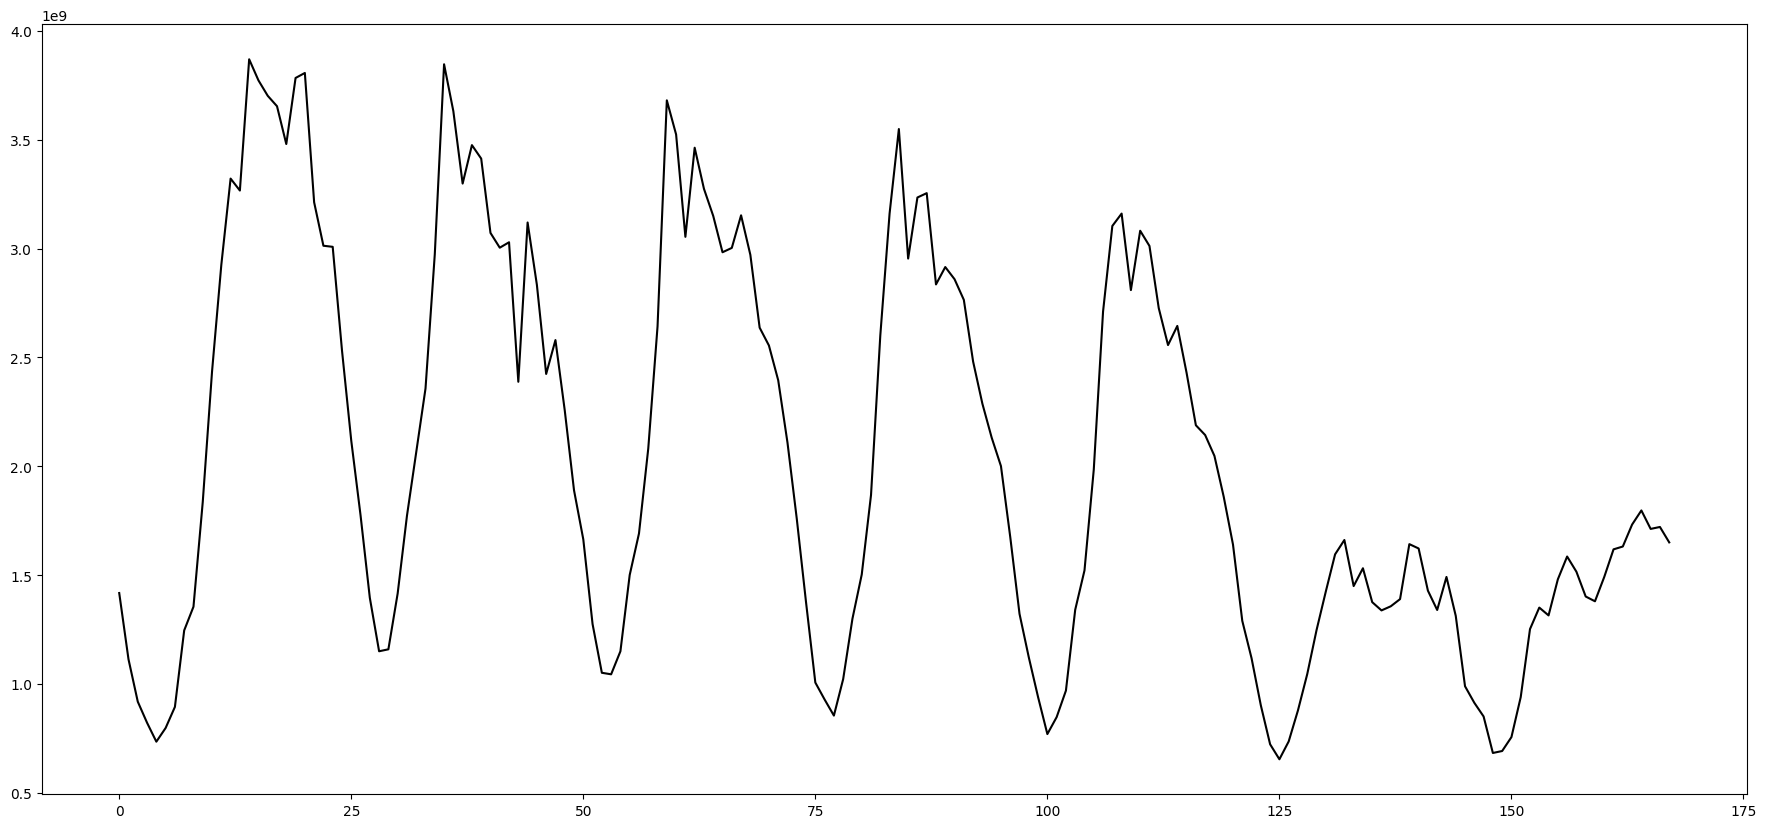

In [ ]:
#first week web traffic
sample = sessions[:168]
ar = np.arange(len(sample))
plt.figure(figsize=(22,10))
plt.plot(ar, sample,'black')
plt.show()

Data Preparation for Web Traffic Forecasting

In [ ]:
def prepare_data(seq,num):
  x=[]
  y=[]
  for i in range(0,(len(seq)-num),1):

    input_ = seq[i:i+num]
    output  = seq[i+num]

    x.append(input_)
    y.append(output)

  return np.array(x), np.array(y)

In [ ]:
num=168 #1 week = 168hrs
x,y= prepare_data(sessions,num)
print(len(x))

4728


Split the Dataset

In [ ]:
ind = int(0.9 * len(x)) #split into 90:10
x_tr = x[:ind]
y_tr = y[:ind]
x_val=x[ind:]
y_val=y[ind:]

In [ ]:
from sklearn.preprocessing import StandardScaler
#normalize the inputs
x_scaler= StandardScaler()
x_tr = x_scaler.fit_transform(x_tr)
x_val= x_scaler.transform(x_val)
#reshaping the output for normalization
y_tr=y_tr.reshape(len(y_tr),1)
y_val=y_val.reshape(len(y_val),1)
#normalize the output
y_scaler=StandardScaler()
y_tr = y_scaler.fit_transform(y_tr)[:,0]
y_val = y_scaler.transform(y_val)[:,0]

In [ ]:
#reshaping input data
x_tr= x_tr.reshape(x_tr.shape[0],x_tr.shape[1],1)
x_val= x_val.reshape(x_val.shape[0],x_val.shape[1],1)
print(x_tr.shape)

(4255, 168, 1)


Model Building for Web Traffic Forecasting

In [ ]:
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from tensorflow import keras
# define model
model =  Sequential()
model.add(LSTM(128,input_shape=(168,1)))
model.add(Dense(64,activation='relu'))
model.add(Dense(1,activation='linear'))

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 128)               66560     
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 74,881
Trainable params: 74,881
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Define the optimizer and loss
model.compile(loss='mse',optimizer='adam')
#Define the callback to save the best model during the training
mc = ModelCheckpoint('best_model.hdf5', monitor='val_loss',
        verbose=1, save_best_only=True, mode='min')
# Train the model for 30 epochs with batch size of 32:
history=model.fit(x_tr, y_tr ,epochs=30, batch_size=32,
           validation_data=(x_val,y_val), callbacks=[mc])

Epoch 1/30
133/133 [==============================] - ETA: 0s - loss: 0.1544
Epoch 1: val_loss improved from inf to 0.03151, saving model to best_model.hdf5
133/133 [==============================] - 32s 191ms/step - loss: 0.1544 - val_loss: 0.0315
Epoch 2/30
133/133 [==============================] - ETA: 0s - loss: 0.0399
Epoch 2: val_loss did not improve from 0.03151
133/133 [==============================] - 19s 141ms/step - loss: 0.0399 - val_loss: 0.0362
Epoch 3/30
133/133 [==============================] - ETA: 0s - loss: 0.0350
Epoch 3: val_loss improved from 0.03151 to 0.03004, saving model to best_model.hdf5
133/133 [==============================] - 18s 136ms/step - loss: 0.0350 - val_loss: 0.0300
Epoch 4/30
133/133 [==============================] - ETA: 0s - loss: 0.0332
Epoch 4: val_loss improved from 0.03004 to 0.02779, saving model to best_model.hdf5
133/133 [==============================] - 24s 182ms/step - loss: 0.0332 - val_loss: 0.0278
Epoch 5/30
133/133 [=========

In [ ]:
model.load_weights('best_model.hdf5')

In [ ]:
mse = model.evaluate(x_val,y_val)
print("Mean Square Error:",mse)


 4/15 [=======>......................] - ETA: 0s - loss: 0.0185

15/15 [==============================] - 1s 64ms/step - loss: 0.0144
Mean Square Error: 0.014384998008608818


Baseline Model with Forecasting

In [ ]:
# build a simple moving average model
def compute_moving_average(data):
  pred=[]
  for i in data:
    avg=np.sum(i)/len(i)
    pred.append(avg)
  return np.array(pred)
# reshape the data
x_reshaped = x_val.reshape(-1,168)
# get predictions
y_pred = compute_moving_average(x_reshaped)
# evaluate the performance of model on the validation data
mse = np.sum ( (y_val - y_pred) **2 ) / (len(y_val))
print("Mean square of error:- ",mse)

Mean square of error:-  0.5546025834434455


Web Traffic Forecasting

In [ ]:
def forecast(x_val, no_of_pred, ind):
  predictions=[]
  #intialize the array with a weeks data
  temp=x_val[ind]
  for i in range(no_of_pred):
    #predict for the next hour
    pred=model.predict(temp.reshape(1,-1,1))[0][0]

    #append the prediction as the last element of array
    temp = np.insert(temp,len(temp),pred)
    predictions.append(pred)
    #ignore the first element of array
    temp = temp[1:]
  return predictions

In [ ]:
no_of_pred =24
ind=72
y_pred= forecast(x_val,no_of_pred,ind)
y_true = y_val[ind:ind+(no_of_pred)]

1/1 [==============================] - 0s 32ms/step


In [ ]:
y_true = np.array(y_true)
y_true = y_true.reshape(-1, 1)

y_pred = np.array(y_pred)
y_pred = y_pred.reshape(-1, 1)
y_true= y_scaler.inverse_transform(y_true)
y_pred= y_scaler.inverse_transform(y_pred)

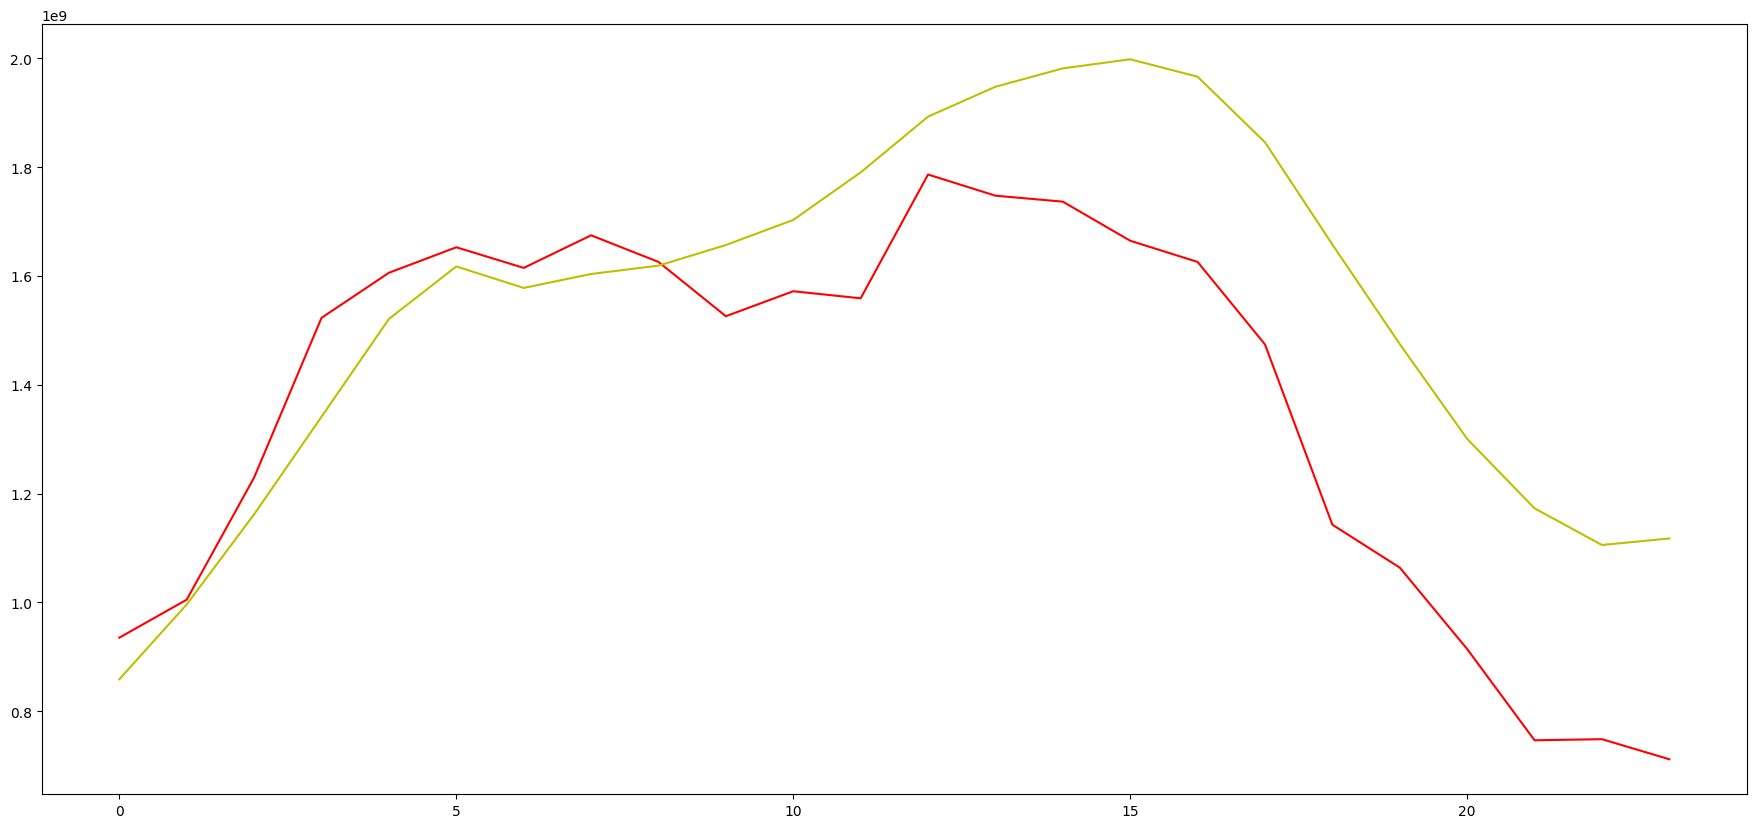

In [ ]:
def plot(y_true,y_pred):
  ar = np.arange(len(y_true))
  plt.figure(figsize=(22,10))
  plt.plot(ar, y_true,'r')
  plt.plot(ar, y_pred,'y')
  plt.show()
plot(y_true,y_pred)

CNN Model with Forecasting

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
model= Sequential()
model.add(Conv1D(64, 3, padding='same', activation='relu',input_shape=(num,1)))
model.add(Conv1D(32, 5, padding='same', activation='relu',input_shape=(num,1)))
model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dense(1,activation='linear'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 168, 64)           256       
                                                                 
 conv1d_3 (Conv1D)           (None, 168, 32)           10272     
                                                                 
 flatten_1 (Flatten)         (None, 5376)              0         
                                                                 
 dense_6 (Dense)             (None, 64)                344128    
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 354,721
Trainable params: 354,721
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Define the optimizer and loss:
model.compile(loss='mse',optimizer='adam')
# Define the callback to save the best model during the training
mc = ModelCheckpoint('best_model.hdf5', monitor='val_loss', verbose=1,
         save_best_only=True, mode='min')
# Train the model for 30 epochs with batch size of 32:
history=model.fit(x_tr, y_tr ,epochs=30, batch_size=32, validation_data=(x_val,y_val),
            callbacks=[mc])

Epoch 1/30
133/133 [==============================] - ETA: 0s - loss: 0.0971
Epoch 1: val_loss improved from inf to 0.04090, saving model to best_model.hdf5
133/133 [==============================] - 3s 19ms/step - loss: 0.0971 - val_loss: 0.0409
Epoch 2/30
131/133 [============================>.] - ETA: 0s - loss: 0.0238
Epoch 2: val_loss improved from 0.04090 to 0.02447, saving model to best_model.hdf5
133/133 [==============================] - 3s 21ms/step - loss: 0.0238 - val_loss: 0.0245
Epoch 3/30
131/133 [============================>.] - ETA: 0s - loss: 0.0172
Epoch 3: val_loss improved from 0.02447 to 0.01884, saving model to best_model.hdf5
133/133 [==============================] - 3s 20ms/step - loss: 0.0174 - val_loss: 0.0188
Epoch 4/30
130/133 [============================>.] - ETA: 0s - loss: 0.0167
Epoch 4: val_loss improved from 0.01884 to 0.01482, saving model to best_model.hdf5
133/133 [==============================] - 3s 20ms/step - loss: 0.0165 - val_loss: 0.0148


In [ ]:
model.load_weights('best_model.hdf5')

In [ ]:
mse = model.evaluate(x_val,y_val)
print("Mean Square Error:",mse)

15/15 [==============================] - 0s 5ms/step - loss: 0.0134
Mean Square Error: 0.013367628678679466


In [ ]:
#build a simple model
def compute_moving_average(data):
  pred=[]
  for i in data:
    avg=np.sum(i)/len(i)
    pred.append(avg)
  return np.array(pred)
x_reshaped = x_val.reshape(-1,168)
y_pred = compute_moving_average(x_reshaped)
mse = np.sum ( (y_val - y_pred) **2 ) / (len(y_val))
print("Mean Square Error:",mse)

Mean Square Error: 0.5546025834434455


In [ ]:
def forecast(x_val, no_of_pred, ind):
  predictions=[]
  #intialize the array with previous weeks data
  temp=x_val[ind]
  for i in range(no_of_pred):
    #predict for the next hour
    pred=model.predict(temp.reshape(1,-1,1))[0][0]

    #append the prediction as the last element of array
    temp = np.insert(temp,len(temp),pred)
    predictions.append(pred)
    #ignore the first element of array
    temp = temp[1:]
  return predictions

In [ ]:
no_of_pred =24
ind=72
y_pred= forecast(x_val,no_of_pred,ind)
y_true = y_val[ind:ind+(no_of_pred)]

1/1 [==============================] - 0s 40ms/step


In [ ]:
y_true = np.array(y_true)
y_true = y_true.reshape(-1, 1)

y_pred = np.array(y_pred)
y_pred = y_pred.reshape(-1, 1)
y_true= y_scaler.inverse_transform(y_true)
y_pred= y_scaler.inverse_transform(y_pred)

In [ ]:
def plot(y_true,y_pred):
  ar = np.arange(len(y_true))
  plt.figure(figsize=(22,10))
  plt.plot(ar, y_true,'r')
  plt.plot(ar, y_pred,'y')
  plt.show()

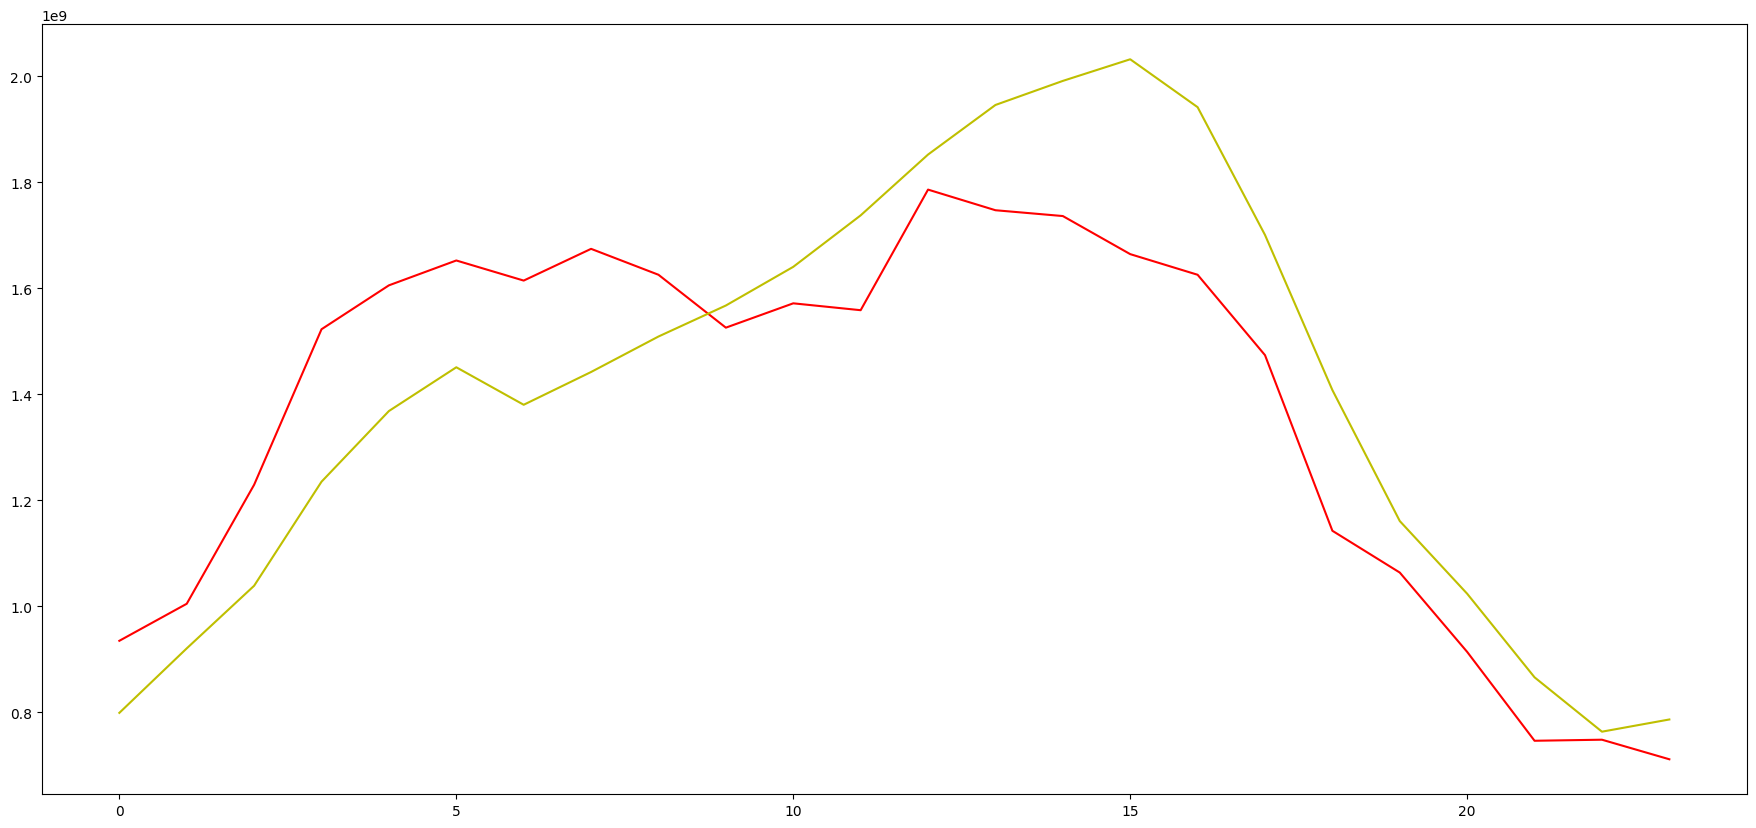

In [ ]:
plot(y_true,y_pred)